<a href="https://colab.research.google.com/github/wagner1986/singular-points/blob/siamese/kornia-single-points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn kornia_moons

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS
from utils.my_dataset import FibersDataset

# Fixar a semente do Torch para operações específicas
fixed_seed()

# MODEL_PATH = "../data/models/model_fibers.pt"
transform2 = transforms.Compose([
    transforms.Resize((120,120), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = FibersDataset(transform=transform2, train=True, path='./data/datasets/fibers/')
testset = FibersDataset(transform=transform2, train=False, path='./data/datasets/fibers/')
print(len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=44,
                                            shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=44,
                                            shuffle=False, num_workers=2)

# Carregar o modelo singular points
# path_single = './data/models/sp_53.pth' # 977/1020
path_single = './data/models/sp_map_fo_30.pth'#1012/1020
# path_single = './data/models/sp_map_fo_45.pth'#996/1020
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_single,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape)
params_lists =AugmentationParamsGenerator(6,img.shape)

['./data/datasets/fibers/doc_000.jpg', './data/datasets/fibers/doc_001.jpg', './data/datasets/fibers/doc_002.jpg', './data/datasets/fibers/doc_003.jpg', './data/datasets/fibers/doc_004.jpg', './data/datasets/fibers/doc_005.jpg', './data/datasets/fibers/doc_006.jpg', './data/datasets/fibers/doc_007.jpg', './data/datasets/fibers/doc_008.jpg', './data/datasets/fibers/doc_010.jpg', './data/datasets/fibers/doc_011.jpg', './data/datasets/fibers/doc_012.jpg', './data/datasets/fibers/doc_0128.jpg', './data/datasets/fibers/doc_0129.jpg', './data/datasets/fibers/doc_013.jpg', './data/datasets/fibers/doc_0130.jpg', './data/datasets/fibers/doc_0131.jpg', './data/datasets/fibers/doc_0132.jpg', './data/datasets/fibers/doc_0133.jpg', './data/datasets/fibers/doc_0134.jpg', './data/datasets/fibers/doc_0135.jpg', './data/datasets/fibers/doc_0136.jpg', './data/datasets/fibers/doc_0137.jpg', './data/datasets/fibers/doc_0138.jpg', './data/datasets/fibers/doc_0139.jpg', './data/datasets/fibers/doc_014.jpg',

/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth
torch.Size([44, 1, 120, 120])


### CustonNetDetector

In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask

from torch import nn

class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary

class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key


In [4]:
from siamesa_e2cnn import Siamesa

def normalize_batch_images(batch_tensor):
    # Verifique o tipo de dados do tensor (pode ser necessário converter para float)
    if batch_tensor.dtype != torch.float32:
        batch_tensor = batch_tensor.float()

    # Verifique se o tensor está no dispositivo correto (CPU ou GPU)
    device = batch_tensor.device

    # Obter o valor máximo possível de intensidade de pixel (255 para imagens em escala de cinza, 1 para imagens RGB)
    max_value = batch_tensor.max()

    # Normalizar o batch de imagens dividindo por max_value
    normalized_batch = batch_tensor / max_value

    return normalized_batch.to(device)

def calcular_momentos_imagem_canal(batch_tensor):
    # Obter as dimensões do batch_tensor
    B, C, H, W = batch_tensor.shape

    # Inicializar listas para armazenar os resultados
    medias = []
    maximos = []
    variancias = []
    assimetrias = []
    curtoses = []

    # Iterar sobre cada imagem do batch
    for b in range(B):
        # Iterar sobre cada canal de cor
        for c in range(C):
            # Obter a imagem atual (um canal de cor)
            imagem = batch_tensor[b, c]
            maximo = torch.max(imagem)
            # Calcular a média (primeiro momento)
            media = torch.mean(imagem)
            # # Calcular a variância (segundo momento)
            variancia = torch.var(imagem)

            # Calcular a assimetria (terceiro momento)
            media_cubica = torch.mean((imagem - media) ** 3)
            desvio_cubico = torch.sqrt(variancia) ** 3
            assimetria = media_cubica / desvio_cubico

            # # Calcular a curtose (quarto momento)
            media_quadrada = torch.mean((imagem - media) ** 4)
            curtose = media_quadrada / variancia ** 2

            # Armazenar os resultados para o canal atual
            medias.append(media.item())
            maximos.append(maximo.item())
            variancias.append(variancia.item())
            assimetrias.append(assimetria.item())
            curtoses.append(curtose.item())

    # Converter as listas para tensores
    medias = torch.tensor(medias).reshape(B, C)
    maximos = torch.tensor(maximos).reshape(B, C)
    variancias = torch.tensor(variancias).reshape(B, C)
    assimetrias = torch.tensor(assimetrias).reshape(B, C)
    curtoses = torch.tensor(curtoses).reshape(B, C)

    # Concatenar os tensores ao longo da dimensão C
    #  output_tensor = torch.cat((medias, maximos, variancias, assimetrias, curtoses), dim=1)
    output_tensor = torch.cat((medias,variancias), dim=1)

    return output_tensor.to(sp.device)

def calcular_histograma_cores(batch_tensor, num_bins=6):
    # Obter as dimensões do batch_tensor
    B, C, H, W = batch_tensor.shape

    # Inicializar tensor para armazenar os resultados
    histogramas = torch.zeros(B, C, num_bins, device=batch_tensor.device)

    # Iterar sobre cada imagem do batch
    for b in range(B):
        # Iterar sobre cada canal de cor
        for c in range(C):
            # Obter a imagem atual (um canal de cor)
            imagem = batch_tensor[b, c]

            # Converter valores de pixel para a escala [0, 1]
            imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min())

            # Multiplicar pelo número de bins para normalizar os valores
            imagem *= (num_bins - 1)

            # Calcular o histograma
            histograma = torch.histc(imagem, bins=num_bins, min=0, max=num_bins - 1)

            # Armazenar o histograma para o canal atual
            histogramas[b, c] = histograma

    # Concatenar os histogramas de cada canal de cor ao longo da dimensão dos canais (dim=1)
    histogramas_concatenados = histogramas.view(B, -1)

    # # Encontrar o valor máximo em cada vetor do batch
    # max_values = torch.max(histogramas_concatenados, dim=1, keepdim=True)[0]
    # # Normalizar cada vetor dividindo pelo valor máximo e multiplicando por 2
    # normalized_histogramas = histogramas_concatenados / max_values * 2
    return histogramas_concatenados


class Descriptor(nn.Module):
        def __init__(self,model,is_simple=True) -> None:
           super().__init__()
           self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
           self.global_max_pool = nn.AdaptiveMaxPool2d(1)
           self.mask=torch.tensor(create_circular_mask(TS.PS,TS.PS)).to(sp.device)
           self.momento = calcular_momentos_imagem_canal
           self.is_simple = is_simple
        def forward(self, x):
            x = x * self.mask[None][None]
            if self.is_simple:
               summary_pool = torch.cat([self.global_avg_pool(x).squeeze(), self.global_max_pool(x).squeeze()], dim=1)
            else:
               summary_pool = self.momento(x)
            return summary_pool

        
detec = Detector(model)
detec2 = Detector2(model)
desc = Descriptor(model,is_simple=False)
TS.PS=13
sift = kornia.feature.SIFTDescriptor(TS.PS, rootsift=True).to(sp.device)
# descriptor = desc.to(sp.device)
descriptor = sift

keynet_default_config = {#990/1020 - fibers 172/220 - 0.78  173/220 - 0.78
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 5, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 14.0},
}

keynet_default_config = {#990/1020 - fibers 176/220 -  num_feat=75 191/220 - 0.87
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 7, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 14.0},
}

# keynet_default_config = {#968/1020 - fibers  162/220 - 0.73
#     'num_filters': 8,
#     'num_levels': 3,
#     'kernel_size': 5,
#     'Detector_conf': {'nms_size': 5, 'pyramid_levels': 3, 'up_levels': 2, 'scale_factor_levels': 1.3, 's_mult': 15.0},
# }



# keynet_default_config = {#1004/1020 - fibers 166/220 - 0.75
#     'num_filters': 8,
#     'num_levels': 3,
#     'kernel_size': 5,
#     'Detector_conf': {'nms_size': 5, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 19.0},
# }


# keynet_default_config = {#1012/1020- fibers 158/220 - 0.72
#     'num_filters': 8,
#     'num_levels': 3,
#     'kernel_size': 5,
#     'Detector_conf': {'nms_size': 5, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.2, 's_mult': 19.0},
# }

detector = CustomNetDetector(detec,PS=TS.PS,keynet_conf=keynet_default_config,num_features=75).to(sp.device)

In [5]:
import matplotlib.pyplot as plt


def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        map = detec2(image[None])
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        print(lafs.shape,patches.shape,PS)
        # patches = kornia.feature.extract_patches_from_pyramid(map, lafs, PS)
        B, N, CH, H, W = patches.size()
        # print('patches  ',patches.shape,B, N, CH, H, W)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        
        return lafs, descs

def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:
            try:
                lafs, descs = detect_and_extract_features(image, detector, descriptor, PS)
                # print('lafs/descs ',lafs.shape,descs.shape)
                repo_lafs_desc.append((lafs,descs))
            except RuntimeError as e:
                plt.imshow(kornia.tensor_to_image(image.cpu()))
                plt.show()
                result = detec(image[None])

                plt.imshow(kornia.tensor_to_image(result.cpu()))
                plt.show()

    return repo_lafs_desc

def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, TS.PS)

        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch

            # matches = bidirectional_match(descs_ref[0], descs_i[0], threshold=0.85)
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9
            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i
        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1, 75, 1, 13, 13]) 13
torch.Size([1, 75, 2, 3]) torch.Size([1,

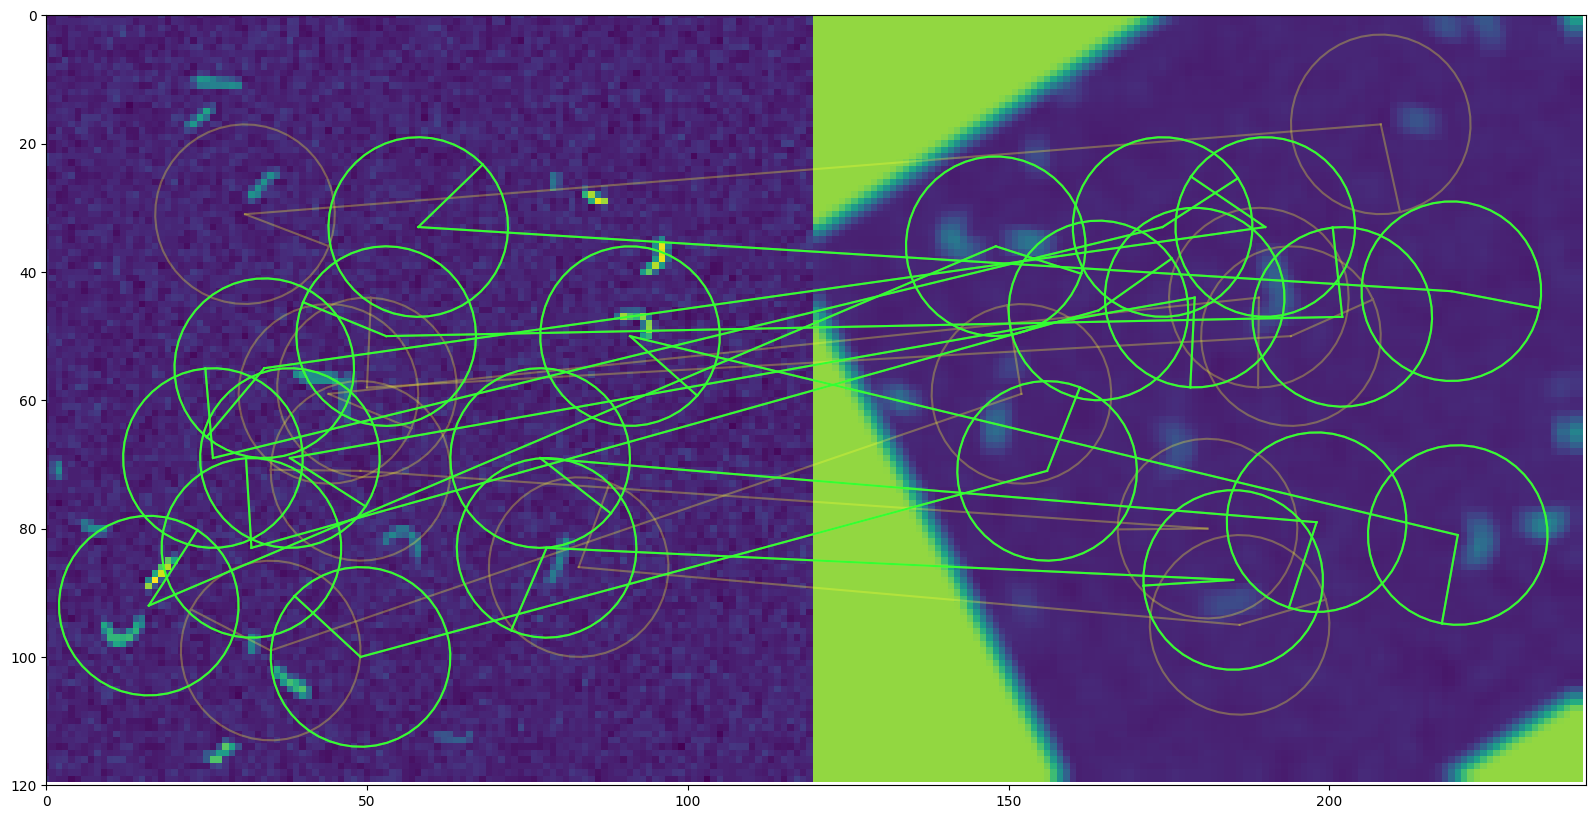

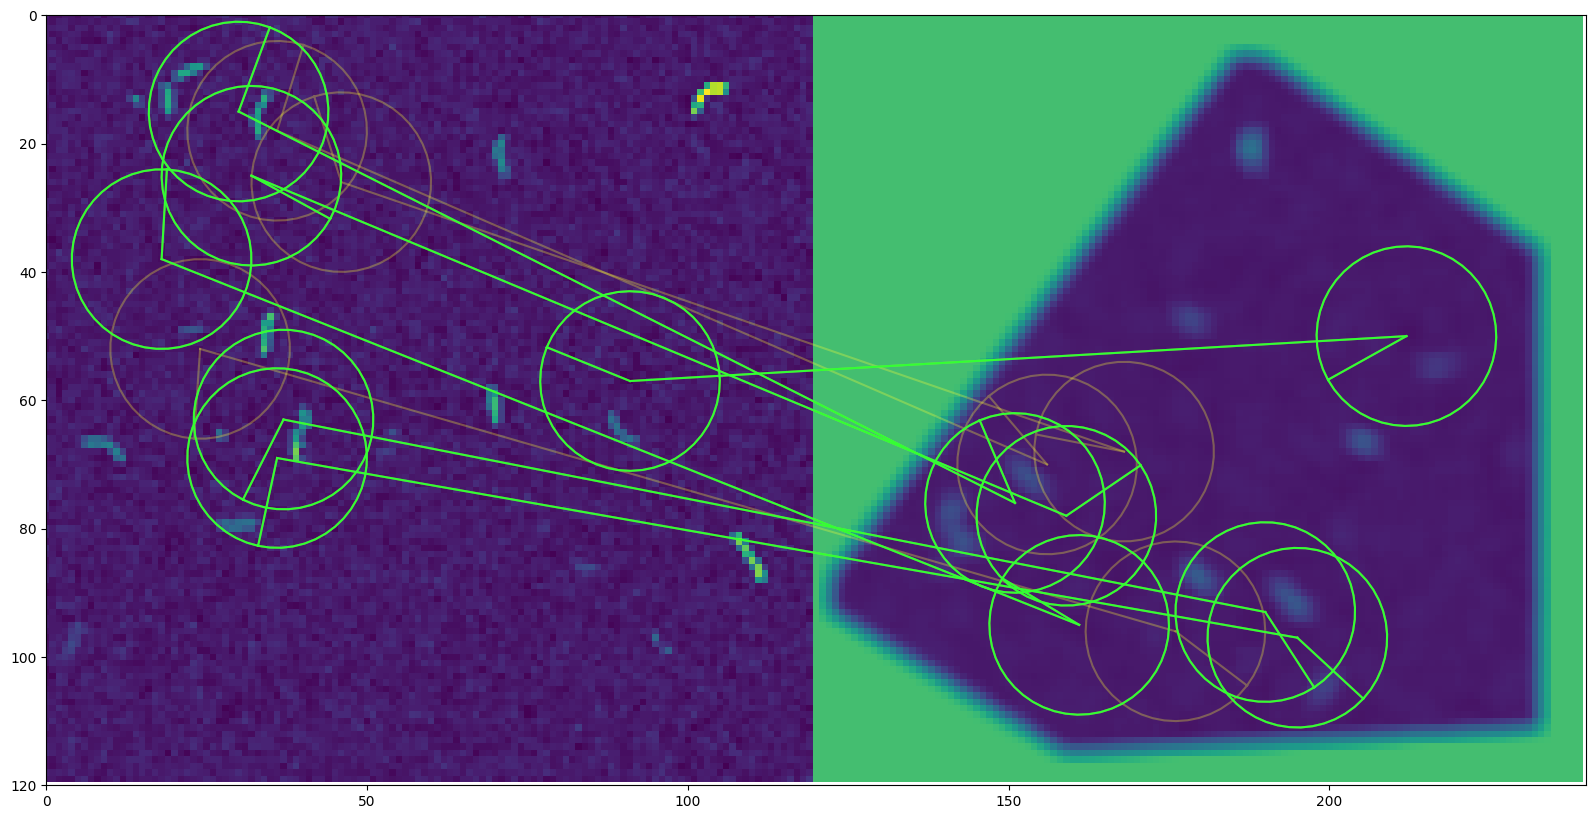

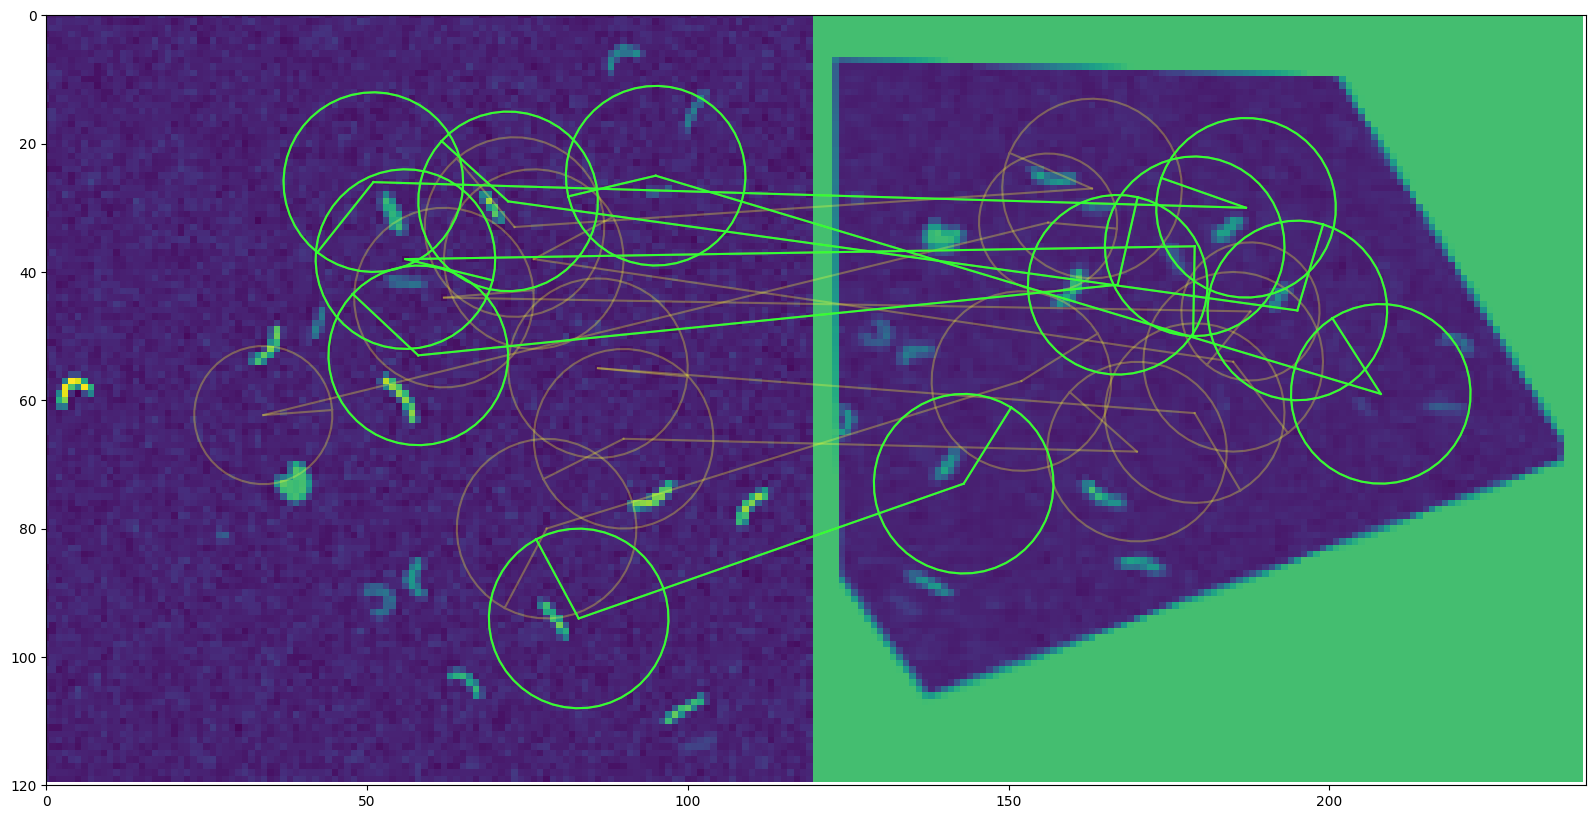

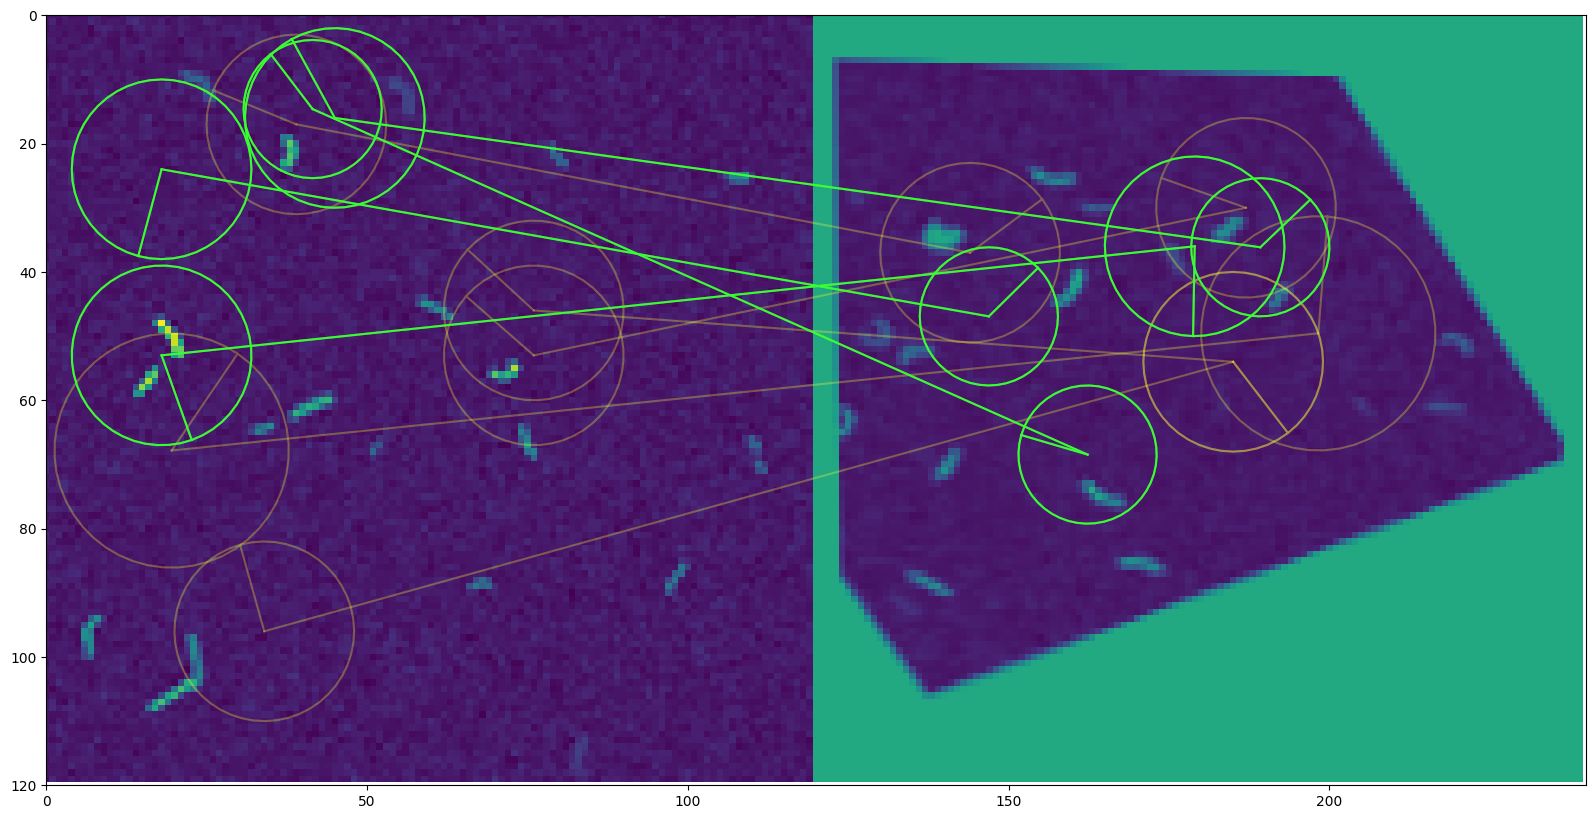

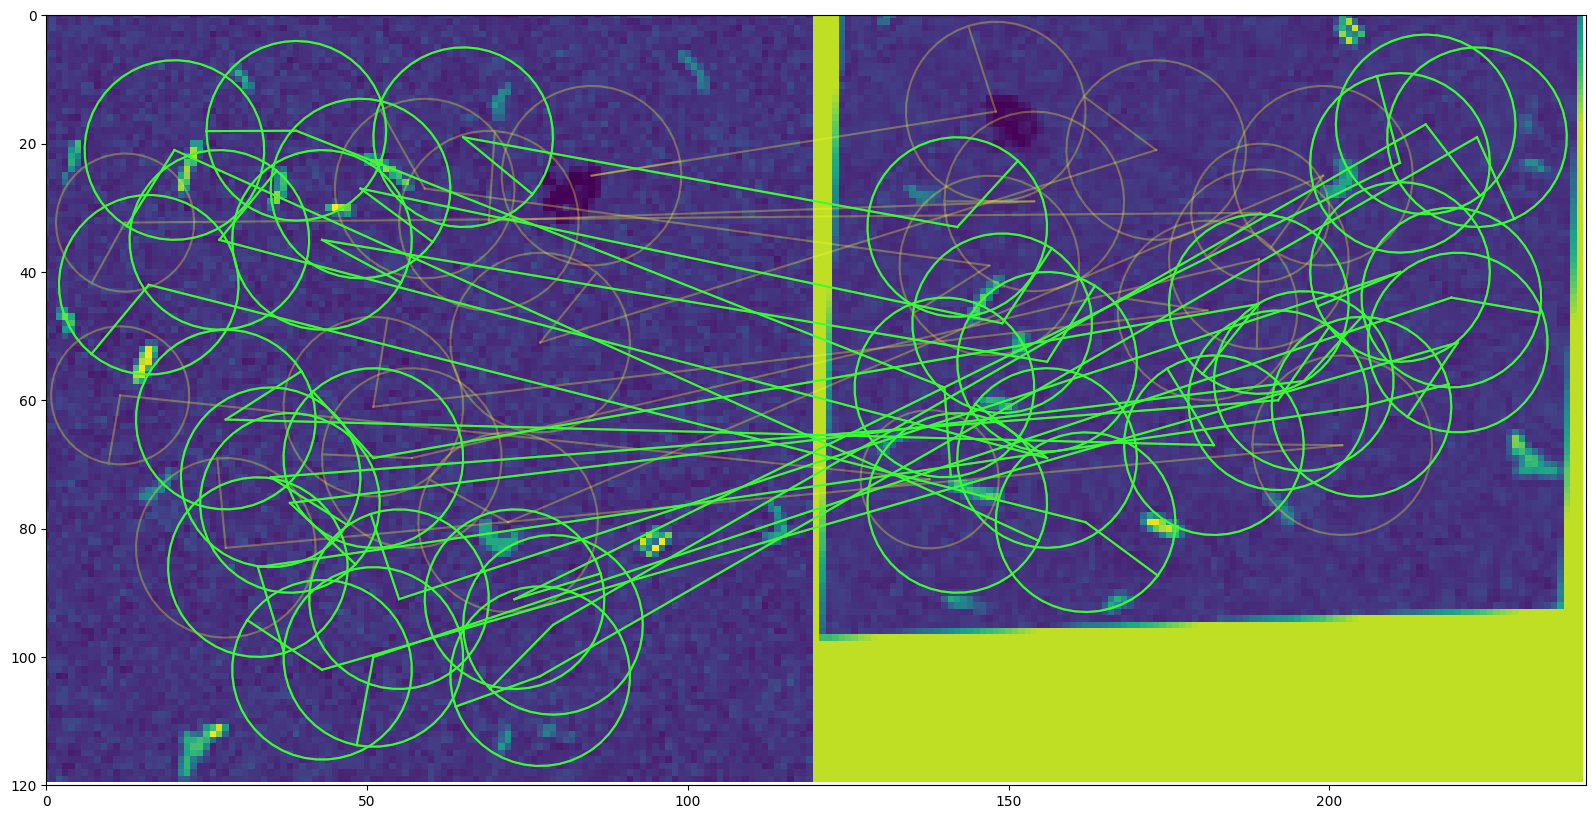

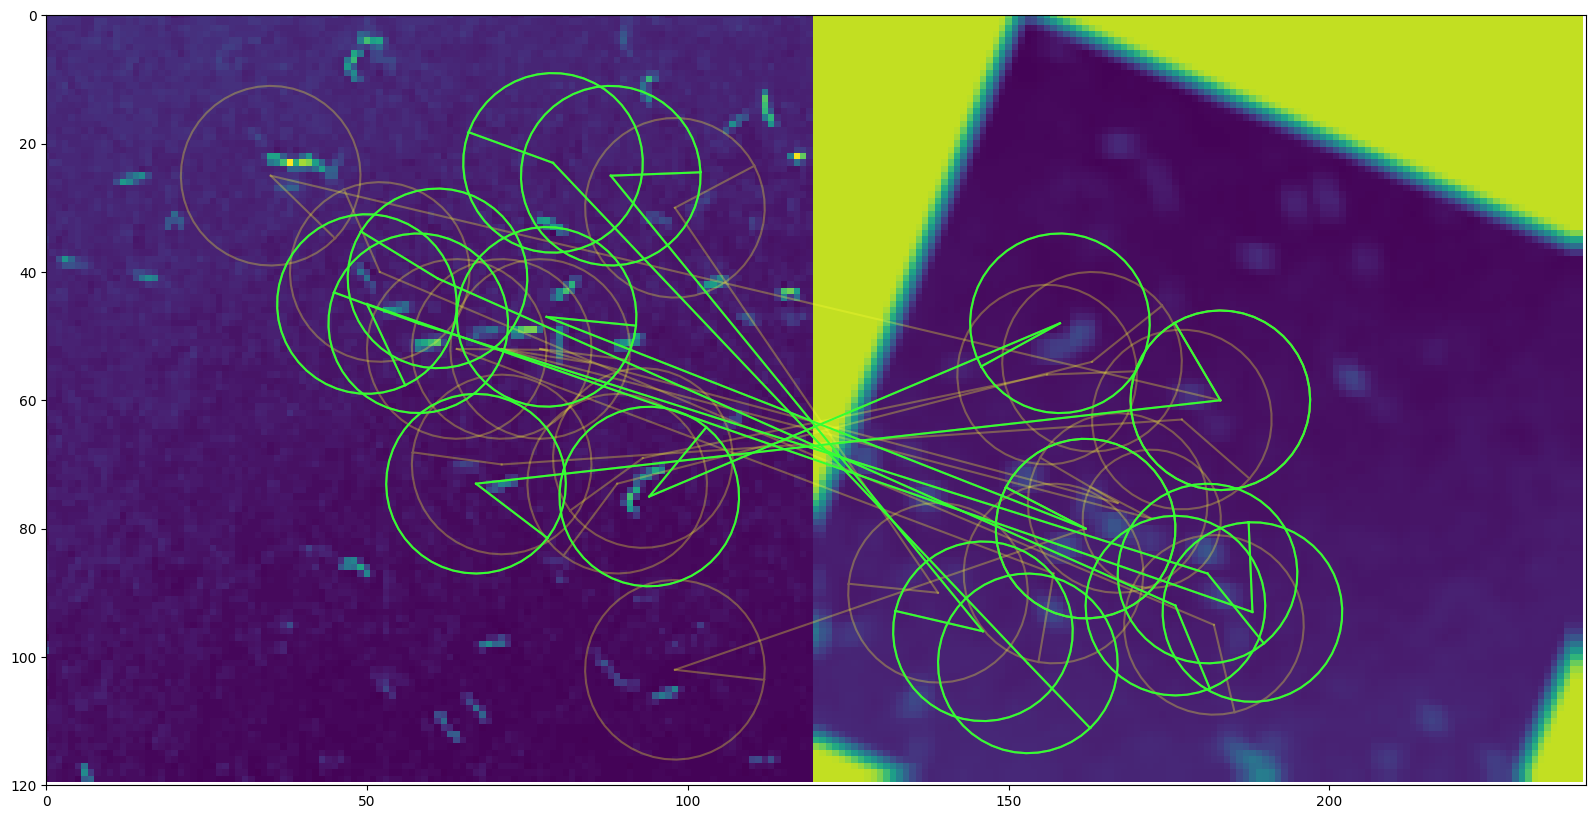

In [6]:
params_lists.aug_list.data_keys =["input"]
aug_list = params_lists.aug_list

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(sp.device)

    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,TS.PS)

    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)